In [6]:
import pandas as pd
import time
import requests
import json

data = pd.read_json("https://data.nsw.gov.au/data/api/3/action/datastore_search?resource_id=2776dbb8-f807-4fb2-b1ed-184a6fc2c8aa&limit=6000")
data = pd.json_normalize(data.result.records)
data = data.query("likely_source_of_infection != 'Overseas'")
data = data[["notification_date", "lga_code19"]]
data.columns = ["date", "code"]
data.date = pd.to_datetime(data.date)
data["cases"] = [1] * len(data)

data.describe(datetime_is_numeric=True)

data = data.groupby(["date", "code"]).sum().reset_index()
data.code = data.code.astype("int")
data.dropna(inplace=True)
data.sort_values("date", inplace=True)

data.describe(datetime_is_numeric=True)

act_data = pd.read_csv("./actCases.csv")
act_data.date = pd.to_datetime(act_data.date, format="%d/%m/%Y")
act_data.sort_values("date", inplace=True)
act_data["code"] = 89399

act_data.describe(datetime_is_numeric=True)

data = pd.concat([data, act_data], ignore_index=True)
date_start = data.date.min()
date_end = data.date.max()
date_length = (date_end - date_start).days

data_chart = pd.DataFrame(columns=["date", "code", "cases"])

count = 0
print("date being processed:")
while date_start + pd.Timedelta(count, unit="d") <= date_end:
    date_current = date_start + pd.Timedelta(count, unit="d")    
    print(date_current, end="\r")
    for code in data.code.unique():
        data_temp = data[(data.date == date_current) & (data.code == code)]
        if len(data_temp) == 0:
            data_chart.loc[len(data_chart)] = [date_current, code, 0]
        else:
            data_chart.loc[len(data_chart)] = [date_current, code, data_temp.iat[0, 2]]
    count = count + 1
print("date processing completed")

timer = time.time()
interval = 1
print("processing recent cases ...", end="\r")
for i, indice in enumerate(data_chart.index):
    data_temp = data_chart[(data_chart.code == data_chart.at[indice, "code"]) & (data_chart.date > data_chart.at[indice, "date"] - pd.Timedelta("14 days")) & (data_chart.date <= data_chart.at[indice, "date"])]
    data_chart.at[indice, "recent"] = data_temp.cases.sum()
    if time.time() - interval > timer:
        interval = interval + 1
        print(f"processing recent cases ... {(i + 1) / len(data_chart):.1%}", end="\r")
print("processing recent cases ... complete")

data_chart.to_csv("./cases.csv", index=False)

plot_data = pd.read_csv("./dataDistance.csv")
for i in plot_data.index:
    plot_data.at[i, "new_cases"] = data_chart[data_chart["code"] == plot_data.at[i, "code"]]["cases"].sum()

for i in plot_data.index:
    r = requests.get(f"http://router.project-osrm.org/route/v1/car/151.179428,-33.947346;{plot_data.at[i, 'location']}?overview=false")
    routes = json.loads(r.content)
    try:
        duration = routes.get("routes")[0]["duration"]
    except:
        duration = 0
    plot_data.at[i, "duration"] = duration

plot_data

date being processed:
date processing completed
processing recent cases ... complete


,code,pop,cases,location,area,new_cases,duration
0,14000,152419,43,"151.0893990562516,-33.58386001730368",455.0375,43.0,4350.0
1,14500,127603,41,"151.15090618099936,-33.73460181503594",85.4096,41.0,2327.6
2,16700,133224,57,"151.1105625315235,-33.79913702935751",40.4748,57.0,1913.7
3,17200,248736,137,"151.2027413754637,-33.88936073927025",26.7429,137.0,911.6
4,15990,274041,155,"151.2496730789337,-33.690202997876334",254.2074,155.0,2618.6
...,...,...,...,...,...,...,...
67,10050,55055,3,"146.9704426335616,-36.02659569023541",305.9459,3.0,22147.6
68,14850,43667,1,"153.27059612238435,-28.756033600388346",1287.7043,1.0,34657.0
69,11350,35773,2,"153.48247399625245,-28.604126965411886",565.8029,2.0,33848.8
70,13010,8873,1,"151.9030034708038,-29.64485217839121",5479.9770,1.0,30125.8


In [7]:
data_pop = pd.read_csv("./lga_pop.csv")
data_pop = data_pop.query("POP_COMP == 10 & TIME == 2020")
data_pop = data_pop[["LGA_2020", "Value"]]
data_pop.columns = ["code", "pop"]

codes = data_chart.code.unique()

df = pd.DataFrame(columns=["code", "pop", "cases"])
df.code = codes

for i in df.index:
    try:
        pop = data_pop[data_pop.code == df.at[i, "code"]].iat[0, 1]
    except:
        pop = 0
    df.at[i, "pop"] = pop
    df.at[i, "cases"] = data_chart[data_chart.code == df.at[i, "code"]].cases.sum()

df.to_csv("data_scatter.csv", index=False)
df

,code,pop,cases
0,14000,152419,43
1,14500,127603,41
2,16700,133224,57
3,17200,248736,137
4,15990,274041,155
...,...,...,...
67,10050,55055,3
68,14850,43667,1
69,11350,35773,2
70,13010,8873,1


<AxesSubplot:xlabel='test', ylabel='new_cases'>

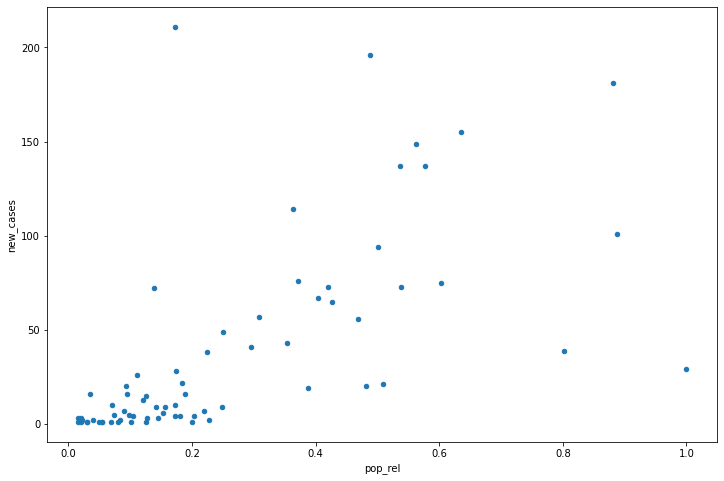

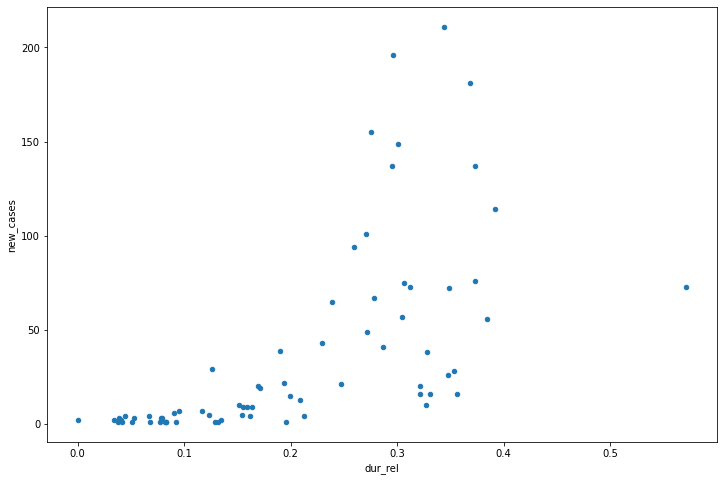

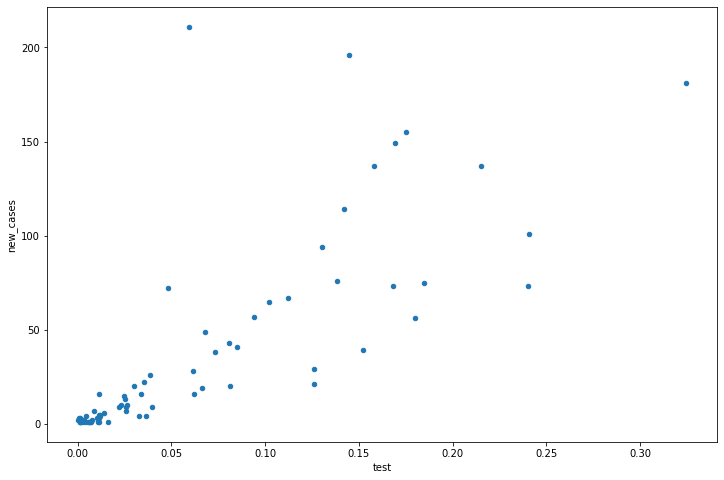

In [15]:
import math

dataPlot = plot_data.query("duration > 0 & pop > 0")
max_pop = dataPlot["pop"].max()
max_dur = dataPlot["duration"].apply(math.log).max()
dataPlot["pop_rel"] = dataPlot["pop"] / max_pop
dataPlot["dur_rel"] = 1 - dataPlot["duration"].apply(math.log) / max_dur
dataPlot["test"] = dataPlot["pop_rel"] * dataPlot["dur_rel"]
dataPlot.corr()

dataPlot.to_csv("data_chart.csv", index=False)

dataPlot.plot.scatter("pop_rel", "new_cases", figsize=(12, 8))
dataPlot.plot.scatter("dur_rel", "new_cases", figsize=(12, 8))
dataPlot.plot.scatter("test", "new_cases", figsize=(12, 8))